In [1]:
!nvidia-smi

Tue Jul 12 17:10:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P3    32W /  N/A |    489MiB /  8192MiB |     32%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 資料讀取與前處理

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# 排序後資料集
df = pd.read_csv("MachineLearningCSV/MachineLearningCVE/week_2.csv")

# 第二資料集
df2 = pd.read_csv("MachineLearningCSV/Seg_NewDataSet/NewDataSet_25679_1.5m.csv")

# 資料集合併
df = pd.concat([df, df2], axis = 0, ignore_index = True)


# 丟掉部分資料
# df = df.drop(["Destination Port"], axis = 1)

# 取部分資料(取前二十特徵)
# df = df[["Flow Duration", "Bwd Packet Length Max", "Bwd Packet Length Min", "Bwd Packet Length Mean", "Bwd Packet Length Std", "Flow IAT Std",
#          "Flow IAT Max", "Fwd IAT Total", "Fwd IAT Std", "Fwd IAT Max", "Min Packet Length", "Max Packet Length", "Packet Length Mean", "Packet Length Std",
#          "Packet Length Variance", "Average Packet Size", "Avg Bwd Segment Size", "Idle Mean", "Idle Max", "Idle Min","Label"]]


df.columns = df.columns.str.strip()
print("original length of df:", len(df))
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("after droping null values, the length of df:", len(df))

original length of df: 4327876
after droping null values, the length of df: 4327876


In [21]:
# 2-calss or Multiclass
df_experiment = df.copy()
df_experiment.Label.replace("Web.*", "Web Attack", regex=True, inplace=True)
df_experiment.Label.replace(r'.*Patator$', "Brute Force", regex=True,inplace=True)
df_experiment.Label.replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS", inplace=True)

# for new dataset, class_attack = ['Syn', 'UDP-lag']
df_experiment.Label.replace(["DrDoS.*", "WebDDoS"], "DDoS", regex=True, inplace=True)


class_attack = ['PortScan', 'Web Attack', 'Brute Force', 'DDoS', 'Bot','Infiltration', 'DoS', 'Heartbleed', 'Syn', 'UDP-lag']
df_experiment.Label.replace(class_attack, value='attack', inplace=True)
df_experiment.Label.value_counts()

BENIGN    2273574
attack    2054302
Name: Label, dtype: int64

In [22]:
# data split and preprocess
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn import preprocessing

y = df_experiment.Label
X = df_experiment.drop(columns='Label')
labels = y.unique()

std_scaler = preprocessing.StandardScaler().fit(X)
X = std_scaler.transform(X)

classes = y.nunique()
print(X.shape)
print("number of labels:", classes)
print("instances per label\n", y.value_counts())
print("labels:", labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
# print(len(df_experiment))
# print(df_experiment.Label.nunique())
# print(df_experiment.Label.value_counts())
print("after spliting the data:\n")
print("training data length:", len(X_train))
print("test data length:", len(X_test))
# print(y_train.nunique())
# print(y_train.value_counts())

(4327876, 20)
number of labels: 2
instances per label
 BENIGN    2273574
attack    2054302
Name: Label, dtype: int64
labels: ['BENIGN' 'attack']
after spliting the data:

training data length: 3245907
test data length: 1081969


In [23]:
# 資料前處理
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
mm_scaler = MinMaxScaler()
le = LabelEncoder()

X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)
print("instances per label in training set\n", y_train.value_counts())
y_train = le.fit_transform(y_train)
print("instances per label in test set\n", y_test.value_counts())
y_test = le.transform(y_test)

print(X_train.shape)
print(X_test.shape)
labels_dict = dict(zip(le.classes_, range(len(le.classes_))))
print(labels_dict)

instances per label in training set
 BENIGN    1705180
attack    1540727
Name: Label, dtype: int64
instances per label in test set
 BENIGN    568394
attack    513575
Name: Label, dtype: int64
(3245907, 20)
(1081969, 20)
{'BENIGN': 0, 'attack': 1}


In [ ]:
# 資料選擇 / 目前沒做
### transform ndarray into dataframe type for later operation.
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

from sklearn.feature_selection import f_classif
### Compute the ANOVA F-value 
f_value = f_classif(X_train, y_train)

# f_value = pd.Series(f_value)
# f_value.index = X_train.columns
# f_value.sort_values(ascending=False)

# ### plot the ordered f_value per feature
# f_value.sort_values(ascending=False).plot.bar(figsize=(20, 8))

### Now we select the top 10 important features based on the result above.
from sklearn.feature_selection import SelectKBest
sel_top_cols = SelectKBest(f_classif, k=10)
sel_top_cols.fit(X_train, y_train)
X_train.columns[sel_top_cols.get_support()]

### transform ndarray back:
X_train = X_train.values
X_test = X_test.values

In [24]:
#儲存資料前處理資料
import joblib as jb

# jb.dump([std_scaler, mm_scaler, le], 'model/std_mm_le_all_feature.save')
jb.dump([std_scaler, mm_scaler, le], 'exe/new_model/25679_std_mm_le_20_feature.save')

['exe/new_model/25679_std_mm_le_20_feature.save']

In [22]:
df_experiment.Label.value_counts()

BENIGN    2272895
attack    2054981
Name: Label, dtype: int64

# Random Forest

In [36]:
###### Random Forest
from sklearn.ensemble import RandomForestClassifier
import joblib as jb

rng = np.random.RandomState(42)

# model = jb.load("new_model/pkl/0.5_randomForest_test.pkl")
model = RandomForestClassifier(n_estimators = 256, random_state=rng)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(y_pred)
print(y_pred.shape)

print("percentage of Anomaly:", (list(y_pred).count(1)/y_pred.shape[0])*100)
print("percentage of Legit:",(list(y_pred).count(0)/y_pred.shape[0])*100)

[0 0 0 ... 1 0 0]
(1081969,)
percentage of Anomaly: 52.031989825956195
percentage of Legit: 47.968010174043805


In [12]:
y.unique()

array(['BENIGN', 'attack'], dtype=object)

In [35]:
# 混淆矩陣
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cf_matrix.ravel()
cf_matrix

array([[518294,  50100],
       [   657, 512918]], dtype=int64)

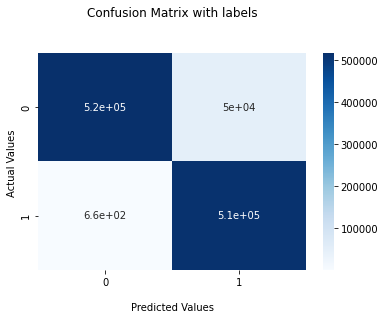

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt 
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(['BENIGN','Attack'])
# ax.yaxis.set_ticklabels(['BENIGN','Attack'])

## Display the visualization of the Confusion Matrix.
plt.show()

# plt.savefig('img/new_confusion_matrix_32.png')
# plt.savefig('new_img/confusion_matrix_20_feature_32_1.5m.png', bbox_inches = 'tight')

In [28]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
def multilabel_matrix(y_true, y_pred, labels=None):
    mlm = multilabel_confusion_matrix(y_true, y_pred, labels=labels)
    df_performance = pd.DataFrame(index=labels, columns=['accuracy', 'precision',
                                                         'recall', 'f1_score', 'support'])
    for i, label in enumerate(labels):
        tn, fp, fn, tp = mlm[i].ravel()
        accuracy = (tn + tp) / (tn + fp + fn + tp)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        support = tp + fn

        f1_score = 2*precision * recall / (precision + recall)
        df_performance.loc[label] = [round(accuracy, 4), round(precision,4), \
                                     round(recall, 4), round(f1_score,4), support]
    return df_performance

In [29]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
y_train_pred_labels = le.inverse_transform(y_pred)
y_train_labels = le.inverse_transform(y_test)
print(classification_report(y_train_labels, y_train_pred_labels))

performance = multilabel_matrix(y_train_pred_labels, y_train_labels, labels=le.classes_)
performance

              precision    recall  f1-score   support

      BENIGN       1.00      0.91      0.95    568394
      attack       0.91      1.00      0.95    513575

    accuracy                           0.95   1081969
   macro avg       0.95      0.96      0.95   1081969
weighted avg       0.96      0.95      0.95   1081969



,accuracy,precision,recall,f1_score,support
BENIGN,0.9532,0.9118,0.999,0.9534,518804
attack,0.9532,0.9989,0.911,0.9529,563165


# 儲存模型檔

In [31]:
# jb.dump(model, 'model/pkl/new_20_feature_randomForest_32.pkl')
jb.dump(model, 'exe/new_model/pkl/25679_randomForest_20_feature_32.pkl')

['exe/new_model/pkl/25679_randomForest_20_feature_32.pkl']